# Breadth First Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using breadth first search


__BREADTH-FIRST-SEARCH__ ( _source_ , _destination_ ) __return__ a route and cost  
&emsp;_frontier_ &larr; a **FIFO** initialized with _source_ node  
&emsp;_explored_ &larr; _empty_    
&emsp;_found_ &larr; _False_  
&emsp;__while__  _frontier_ __is not__ _empty_ __and__ _found_ __is__ _False_ __do__  
&emsp;&emsp;&emsp;_node_ &larr; _frontier_.pop()   
&emsp;&emsp;&emsp;__add__ _node_ __to__ _explored_    
&emsp;&emsp;&emsp;__for__ _child_ __in__ _node_.expand() __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _child_ __is not in__ _explored_ __and__ _child_ __is not in__ _frontier_   __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; __if__ _child_ __is__ _destination_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _route_ &larr; _child_.route()  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; _found_ &larr; _True_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__add__ _child_ __to__ _frontier_    
&emsp;__return__  _route_

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet

# You need to upload Utilities.zip in /content directory which is the default
!unzip Utilities.zip

In [1]:
import osmnx as ox
import time
from tqdm import tqdm
from collections import deque
from Utilities.utils import *

Here OSMnx find the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

In [ ]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
G.nodes

In [ ]:
G[50897923]

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the osmid of the nodes for destination and source are 389677909, 55808290 respectively

In [ ]:
highlighted = [389677909, 55808290]

# marking both the source and destination node

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [ ]:
draw_map(G, highlight = highlighted)

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing.

Please check its source code in ```./Utilities/utils/oxm.py``` to know how it capture the data from the graph

In [ ]:
%%capture
source(Node)

# The Algorithm

In [ ]:
# first define the origin/source nodes as Node
origin = Node(graph = G, osmid = 55808290)
destination = Node(graph = G, osmid = 389677909)

In [ ]:
bar = tqdm(total=len(G))

route = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.popleft()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
            frontier.append(child)

bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost)

In [ ]:
fig, ax = ox.plot_graph_route(G, route)

In [ ]:
draw_route(G, route)

In [6]:
G = ox.graph_from_xml("./export.osm", retain_all = True)

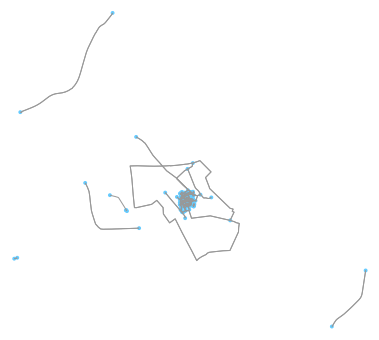

In [7]:
fig, ax = ox.plot_graph(G)

In [10]:
G1 = ox.graph_to_gdfs(G)

In [11]:
G1[0]

,y,x,osmid,highway,geometry
31941906,50.737975,7.114133,31941906,NaN,POINT (7.11413 50.73798)
33078439,50.747999,7.150115,33078439,traffic_signals,POINT (7.15011 50.74800)
51289968,50.744062,7.154970,51289968,NaN,POINT (7.15497 50.74406)
56553599,50.775645,7.137325,56553599,NaN,POINT (7.13732 50.77565)
69291476,50.736020,7.198858,69291476,NaN,POINT (7.19886 50.73602)
...,...,...,...,...,...
6873531529,50.747102,7.154193,6873531529,NaN,POINT (7.15419 50.74710)
6873531530,50.747110,7.154185,6873531530,NaN,POINT (7.15419 50.74711)
6874227823,50.752545,7.156837,6874227823,NaN,POINT (7.15684 50.75254)
7532007566,50.747869,7.156775,7532007566,NaN,POINT (7.15678 50.74787)


In [12]:
G1[1]

,u,v,key,osmid,name,highway,oneway,length,geometry,maxspeed,bridge,lanes,ref,service,access
0,31941906,1380744830,0,123945726,Hans-Steger-Ufer,cycleway,False,55.158,"LINESTRING (7.11413 50.73798, 7.11406 50.73793...",NaN,NaN,NaN,NaN,NaN,NaN
1,33078439,51289968,0,"[32501184, 6174257]","[Friedenstraße, Sebastianusstraße]",residential,False,560.005,"LINESTRING (7.15011 50.74800, 7.15014 50.74798...",30,NaN,NaN,NaN,NaN,NaN
2,51289968,33078439,0,"[32501184, 6174257]","[Friedenstraße, Sebastianusstraße]",residential,False,560.005,"LINESTRING (7.15497 50.74406, 7.15494 50.74424...",30,NaN,NaN,NaN,NaN,NaN
3,56553599,254142774,0,"[34585408, 295167373, 295167374, 32550322, 295...",NaN,"[path, cycleway]",False,2489.244,"LINESTRING (7.13732 50.77565, 7.13727 50.77554...",NaN,yes,NaN,NaN,NaN,NaN
4,69291476,69291487,0,"[31047685, 129988070, 75027463]",Ungartenstraße,tertiary,False,1177.782,"LINESTRING (7.19886 50.73602, 7.19871 50.73538...","[70, 50]",NaN,2,K 8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,6874227823,274246241,2,238669065,NaN,NaN,False,2233.651,"LINESTRING (7.15684 50.75254, 7.15666 50.75203...",NaN,NaN,NaN,NaN,NaN,NaN
800,7532007566,1558201831,0,31347483,Alte Schulstraße,residential,False,32.816,"LINESTRING (7.15678 50.74787, 7.15675 50.74788...",30,NaN,NaN,NaN,NaN,NaN
801,7532007566,96133770,0,"[142380547, 31347483]",Alte Schulstraße,residential,False,147.937,"LINESTRING (7.15678 50.74787, 7.15699 50.74775...",30,NaN,NaN,NaN,NaN,NaN
802,7532007566,7532007570,0,805324291,NaN,service,False,54.859,"LINESTRING (7.15678 50.74787, 7.15710 50.74800...",NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from time import sleep
from ipyleaflet import *

m = Map(center=(52, 10), zoom=8, basemap=basemaps.Hydda.Full)



In [7]:
mark = Marker(location=(51.5, 10))
m.add_layer(mark)
nb_steps = 10
step = 0.1
start_location = mark.location
end_location = (52.2, 10)

for i in range(nb_steps + 1):
    precentage_animation = i / nb_steps
    a = 1 - precentage_animation
    b = precentage_animation
    mark.location = (a * start_location[0] + b * end_location[0], a*start_location[1] + b*end_location[1])
    sleep(step)